# n-step Temporal Difference

MC is an infinite-step method: it goes all the way until the end of the episode; TD is a one-step method: it interacts with the environment for a single step. We can generalize into an n-step method.

The hyperparameter alpha.

In [1]:
import numpy as np

def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

We need a function to generate the sub-path of n steps:

In [2]:
def generate_path(pi, env, state, n_steps):
    path = []
    done = False
    while len(path) < n_steps:
        action = pi(state) 
        next_state, reward, done, _ = env.step(action)
        experience = (state, action, reward, next_state, done)
        path.append(experience)
        if done: 
            break
        state = next_state
    return np.array(path, object)

We write the prediction function that works for n-steps Temporal-Difference:

In [3]:
def ntd(pi, env, gamma=1.0,
        init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
        n_steps=3, n_episodes=500):
    
    nS = env.observation_space.n
    
    # notice a hybrid between MC and TD: we calculate the discount factors, 
    # but instead of going to max_steps like in MC implementation, 
    # we go to n_step + 1 to include n steps and the bootstrapping estimate
    discounts = np.logspace(0, n_steps+1, num=n_steps+1, base=gamma, endpoint=False)
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
      
    # initialize the current estimate of the state-value function V
    # and a per-episode copy of V for offline analysis
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # loop for every episode 
    for e in range(n_episodes):

        # get the initial state
        state, done = env.reset(), False

        # go collecting a series of n-state paths until we hit done
        while not done:
            # generate a path of n-steps (maximim, or less if we hit done)
            path = generate_path(pi, env, state, n_steps)
            
            # calculate the number of steps, could be ‘n_step’ but it could 
            # also be a smaller if a terminal state is in the path    
            n = len(path)
        
            # initialize a visits check vector
            visited = np.zeros(nS, dtype=bool)
        
            # now loop through all experiences in the path
            for t, (path_state, _, reward, path_next_state, path_done) in enumerate(path):                
                # calculate the partial return
                partial_return = np.sum(discounts[:n-t] * path[t:, 2])
            
                # update the value function
                ntd_target = partial_return + discounts[n] * V[path[n-1, 3]]  * (not path_done)
                ntd_error = ntd_target - V[path_state]
                V[path_state] = V[path_state] + alphas[e] * ntd_error
                                           
                state = path_next_state
                done = path_done
                
        # keep track of the episode’s V
        V_track[e] = V
                      
    return V.copy(), V_track

We ran the policy evaluation algorithms on the Random Walk (RW) environment.

In [4]:
class Space:
    def __init__(self, value):
        self.n = value 
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(7)
        self._state = np.random.choice([1,2,3,4,5])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        self._state += np.random.choice([-1, 1])
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [5]:
env = RandomWalk()

We evaluate an "all-left" policy

In [6]:
def pi(state):
    return 1

We use the n-step Temporal-Difference prediction algorithm and show the estimates over episodes

In [7]:
V_ntd, V_ntd_track = ntd(pi, env, n_steps=3, n_episodes=500)

In [8]:
print(V_ntd)

[0.         0.20701101 0.36753225 0.54133397 0.69862047 0.8436858
 0.        ]


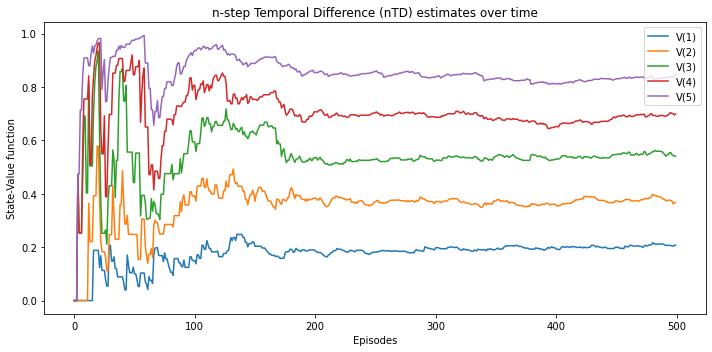

In [9]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)']
plt.figure(figsize=(10,5))
plt.plot(V_ntd_track[:,1:6])
plt.title('n-step Temporal Difference (nTD) estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()